In [67]:
import json
import os
import torch
import pandas as pd
import numpy as np
import faiss
import pyarrow.parquet as pq
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col, when, count, explode, rank, sum as _sum
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from collections import Counter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List, Dict, Any, Optional
from pyarrow import json

## Final Assignment Overview: Working with Patient Records and Encounter Notes

In this final assignment, we’ll focus on patient records related to COVID-19 encounters. Our task is to analyze, process, and transform the data while applying the concepts we’ve covered throughout this course. Here's a detailed breakdown of the assignment:

What Are Encounter Notes?
An encounter note is a record that captures details about a patient’s visit with a doctor. It includes both structured and semi-structured information that is crucial for understanding the context of the visit. Here’s what an encounter note typically looks like:


The encounter contains:

* General encounter information: 

  * When the encounter took place: Date and time of the visit.
  * Demographics: Patient’s age, gender, and unique medical record identifier.
  * Encounter details: The reason for the visit, diagnosis, and any associated costs.


Semi-Structured Notes:

These notes mirror how doctors organize their thoughts and observations during an encounter. They generally follow a SOAP format:

* **Subjective**: The patient’s subjective description of their symptoms, feelings, and medical concerns.
* **Objective**: The doctor’s objective findings, including test results, measurements, or physical examination outcomes.
* **Assessment**: The doctor’s evaluation or diagnosis based on subjective and objective information.
* **Plan**: The proposed treatment plan, including medications, follow-ups, or other interventions.

While some encounter notes might include additional details, the majority conform to this semi-structured format, making them ideal for analysis and transformation.

* Goals for the Assignment

## 1. Transforming Encounter Notes:

Using an LLM to convert semi-structured encounter notes into a JSON format that organizes the information into structured fields. The JSON will include details such as demographics, encounter specifics, and the SOAP components of the note. Subsequently, you will need to transform the JSON data into a Parquet file, which is not only suitable for analysis in Spark but also ideal for storage later.
Here we will use the ML classificaition to assing the objective and assessment semi-structured fields into standardized, structured fields. The medical taxonomy for this task will be the one provided by the CDC, which defines standard codes for diagnoses, symptoms, procedures, and treatments. This step ensures the structured data aligns with domain-wide medical standards, making it interoperable and ready for deeper analysis.

The JSON format should capture the hierachies described in the structure below. 


## 2. Basic Analytics and Visualizations:
Using Apache Spark, perform comprehensive data analysis on the encounter data and create visualizations that reveal meaningful patterns. Your analysis must include:
- COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])
- Cumulative case count of Covid between the earliest case observed in the dataset and last case observed

- Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.
- *This will use encounters_assignment_1.csv and encounters_types_assignment_1.csv: Intensive care unit has a specific encounter code; then we can*

- Rank medications by frequency of prescription
- Analyze medication patterns across different demographic groups (e.g., top 3 per age group)
- Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset. 

- An independent group analysis: You need to develop and execute **THREE original analyses** that provide meaningful insights about COVID-19 patterns in this dataset. For each analysis:
  - Clearly state your analytical question/hypothesis
  - Justify why this analysis is valuable
  - Show your Spark code and methodology
  - Present results with appropriate visualizations
  
The analyses should be actionable, informative, and helpful with regard to the dataset.

In [68]:
# Correct way to use os.walk()
file_paths = []
for root, dirs, files in os.walk('data/encounter_notes/'):
    for file in files:
        file_paths.append(os.path.join(root, file))

In [69]:
def read_file(file):
    with open(file, 'r') as f:
        return f.read()

file_contents = [read_file(file) for file in file_paths]

In [70]:
class EncounterType(BaseModel):
    code: Optional[str] = None
    description: Optional[str] = None

class Address(BaseModel):
    city: Optional[str] = None
    state: Optional[str] = None

class Demographics(BaseModel):
    name: Optional[str] = None
    date_of_birth: Optional[str] = None
    age: Optional[str] = None
    gender: Optional[str] = None
    address: Optional[Address] = None
    insurance: Optional[str] = None

class Encounter(BaseModel):
    date: Optional[str] = None
    time: Optional[str] = None
    type: Optional[EncounterType] = None
    provider_id: Optional[str] = None
    facility_id: Optional[str] = None

class Condition(BaseModel):
    code: Optional[str] = None
    description: Optional[str] = None

class Medication(BaseModel):
    code: Optional[str] = None
    description: Optional[str] = None

class Immunization(BaseModel):
    code: Optional[str] = None
    description: Optional[str] = None
    date: Optional[str] = None

class VitalMeasurement(BaseModel):
    code: Optional[str] = None
    value: Optional[float] = None
    unit: Optional[str] = None

class BloodPressure(BaseModel):
    systolic: Optional[VitalMeasurement] = None
    diastolic: Optional[VitalMeasurement] = None

class CurrentVitals(BaseModel):
    temperature: Optional[VitalMeasurement] = None
    heart_rate: Optional[VitalMeasurement] = None
    blood_pressure: Optional[BloodPressure] = None
    respiratory_rate: Optional[VitalMeasurement] = None
    oxygen_saturation: Optional[VitalMeasurement] = None
    weight: Optional[VitalMeasurement] = None

class BaselineVitals(BaseModel):
    date: Optional[str] = None
    height: Optional[VitalMeasurement] = None
    weight: Optional[VitalMeasurement] = None
    bmi: Optional[VitalMeasurement] = None
    bmi_percentile: Optional[VitalMeasurement] = None

class Vitals(BaseModel):
    current: Optional[CurrentVitals] = None
    baseline: Optional[BaselineVitals] = None

class RespiratoryTest(BaseModel):
    code: Optional[str] = None
    result: Optional[str] = None

class RespiratoryPanel(BaseModel):
    influenza_a: Optional[RespiratoryTest] = None
    influenza_b: Optional[RespiratoryTest] = None
    rsv: Optional[RespiratoryTest] = None
    parainfluenza_1: Optional[RespiratoryTest] = None
    parainfluenza_2: Optional[RespiratoryTest] = None
    parainfluenza_3: Optional[RespiratoryTest] = None
    rhinovirus: Optional[RespiratoryTest] = None
    metapneumovirus: Optional[RespiratoryTest] = None
    adenovirus: Optional[RespiratoryTest] = None

class Covid19Test(BaseModel):
    code: Optional[str] = None
    description: Optional[str] = None
    result: Optional[str] = None

class Laboratory(BaseModel):
    covid19: Optional[Covid19Test] = None
    respiratory_panel: Optional[RespiratoryPanel] = None

class Procedure(BaseModel):
    code: Optional[str] = None
    description: Optional[str] = None
    date: Optional[str] = None
    reasonCode: Optional[str] = None
    reasonDescription: Optional[str] = None

class CarePlan(BaseModel):
    code: Optional[str] = None
    description: Optional[str] = None
    start: Optional[str] = None
    stop: Optional[str] = None
    reasonCode: Optional[str] = None
    reasonDescription: Optional[str] = None

class PatientRecord(BaseModel):
    encounter: Optional[Encounter] = None
    demographics: Optional[Demographics] = None
    conditions: Optional[List[Condition]] = None
    medications: Optional[List[Medication]] = None
    immunizations: Optional[List[Immunization]] = None
    vitals: Optional[Vitals] = None
    laboratory: Optional[Laboratory] = None
    procedures: Optional[List[Procedure]] = None


In [71]:
api_key = "" # supply api_key

llm = ChatOpenAI(
  model="gpt-4o-mini",
  api_key=api_key
)
structured_llm = llm.with_structured_output(PatientRecord, include_raw=True)

# Create a prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful medical assistant. Extract key information precisely."),
    ("human", "{patient_note}")
])

# Combine the prompt with the structured output, this is a test tha should be deleted later
chain = prompt | structured_llm

def extract_info_1(patient_note):
    try:
        result = chain.invoke({"patient_note": patient_note})
        return result
    except Exception as e:
        print(f"Error in extraction: {e}")
        return None

In [72]:
patient_records = []
for record in file_contents:
    patient_records.append((extract_info_1(record)))    

In [73]:
patient_records_1 = [record['parsed'] for record in patient_records]

# Find most similar values to first-pass extracted information
We need to now look at our database (csv files) to get the relevant codes that may exist for each extracted piece of data. These should be:
- medications
- immunizations
- encounter type
- observation (note that I don't think there is a header on this one)

I believe we need to create embeddings for these missing data and then use FAISS to find the top 10 most similar values to these embeddings

In [74]:
spark = SparkSession \
    .builder \
    .appName("faiss-similarity") \
    .getOrCreate()

In [75]:
encounter_types = spark.read.format("csv").option("header", "true").load("data/encounters_types_assignment_1.csv")

immunizations_df = spark.read.format("csv").option("header", "true").load("data/immunizations_assignment_1.csv")

medications_df = spark.read.format("csv").option("header", "true").load("data/medications_assignment_1.csv")

observations = spark.read.format("csv").option("header", "true").load("data/observations_assignment_1.csv")

encounters = spark.read.format("csv").option("header", "true").load("data/encounters_assignment_1.csv")

In [76]:
# Load the model on the specified device
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embeddings(titles): # titles is a list of strings? 
    return model.encode(titles, convert_to_numpy=True) # Specify device for embedding generation

# Index embeddings using FAISS
def create_faiss_index(embeddings):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index

In [77]:
existing_medication_codes = medications_df.select("CODE").rdd.flatMap(lambda x: x).collect()
existing_medications = medications_df.select("DESCRIPTION").rdd.flatMap(lambda x: x).collect()
medications_embeddings = generate_embeddings(existing_medications)
medications_index = create_faiss_index(medications_embeddings)

In [78]:
existing_immunization_codes = immunizations_df.select("CODE").rdd.flatMap(lambda x: x).collect()
existing_immunizations = immunizations_df.select("DESCRIPTION").rdd.flatMap(lambda x: x).collect()
immunizations_embeddings = generate_embeddings(existing_immunizations)
immunizations_index = create_faiss_index(immunizations_embeddings)

In [79]:
# each time this function is run it should be for ONE document. 
def classify_titles(new_titles: List[str], existing_titles: List[str], existing_codes: List[Any], index, k: int = 1) -> List[Dict[str, Any]]:
    """
    Parameters:
    - new_titles (List[str]): List of new titles to classify.
    - existing_titles (List[str]): List of existing titles.
    - existing_codes (List[Any]): List of corresponding codes for each title.
    - index: FAISS index built from embeddings.
    - k (int, optional): Number of neighbors to consider for classification. Default is 5.

    Returns:
    - List[Dict[str, Any]]: A list of dictionaries, where each dictionary contains:
        - 'query_title': The title of the query article.
        - 'nearest_neighbors': A list of k nearest neighbors with their titles and codes.

    Example:
    >>> classify_titles(["New Title"], ["Existing Title"], ["Code1"], index)
    [{'query_title': 'New Title', 
      'nearest_neighbors': [{'title': 'Existing Title', 'code': 'Code1'}]}]
    """
    new_embeddings = model.encode(new_titles, convert_to_numpy=True) # Generate embeddings for new titles
    distances, indices = index.search(new_embeddings, k) # Search FAISS index for k nearest neighbors

    results = []
    
    for i, query_title in enumerate(new_titles):
        
        neighbors = []
        for neighbor_idx in indices[i].tolist():
            neighbors.append({
                'title': existing_titles[neighbor_idx],
                'code': existing_codes[neighbor_idx]
            })
        
        results.append({
            'query_title': query_title,
            'nearest_neighbors': neighbors
        })

    return results

In [80]:
# MEDICATIONS
medication_record_codes = []
for record in patient_records_1:
    if record.medications:  # This will return True if medications is not empty
        medications = record.medications
        codes = []
        
        for medication in medications:
            if medication.code: # Ensure that medication has the 'code' attribute
                codes.append(medication.code)
        medication_record_codes.append(codes)

In [81]:
# IMMUNIZATIONS
immunization_record_codes = []
for record in patient_records_1:
    if record.immunizations:
        immunizations = record.immunizations
        codes = []
        
        for immunization in immunizations:
            if immunization.code:
                codes.append(immunization.code)
        
        immunization_record_codes.append(codes)

In [82]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

medication_record_codes = list(set(flatten(medication_record_codes)))
immunization_record_codes = list(set(flatten(immunization_record_codes)))

In [83]:
def replace_medications_and_immunizations(
    patient_records: list,
    faiss_results: dict,
    field: str
):
    """
    Replace medication or immunization codes in patient records using FAISS results.

    Parameters:
    - patient_records (list): List of `PatientRecord` objects.
    - faiss_results (dict): FAISS results mapping query titles to their nearest codes.
      Example: {'1 ML medroxyPROGETERone acetate 150 MG/ML Injection': '1000126'}
    - field (str): The field to update ('medications' or 'immunizations').

    Returns:
    - list: Updated patient records.
    """
    for record in patient_records:
        items = getattr(record, field, None)
        if items:
            for item in items:
                if item.code in faiss_results:
                    item.code = faiss_results[item.code]["nearest_neighbors"][0]["code"]  # Replace with the top nearest code
    return patient_records


In [84]:
faiss_results_medications = []
for medication in medication_record_codes:
    faiss_result = classify_titles(
        [medication],
        existing_medications,
        existing_medication_codes,
        medications_index
    )
    faiss_results_medications.append(faiss_result)
    

In [85]:
faiss_results_immunizations = []
for immunization in immunization_record_codes:
    faiss_result = classify_titles(
        [immunization],
        existing_immunizations,
        existing_immunization_codes,
        immunizations_index
    )
    faiss_results_immunizations.append(faiss_result)
    

In [86]:
def generate_replacement_mapping(faiss_results: List[List[Dict[str, Any]]]) -> List[Dict[str, Any]]:
    """
    Generate replacement mapping from FAISS results.

    Parameters:
    - faiss_results (List[List[Dict[str, Any]]]): FAISS result for medications or immunizations.

    Returns:
    - List[Dict[str, Any]]: A list of mappings containing the original name (query_title) and replacement code.
    """
    replacement_mapping = []

    # Iterate over the FAISS results for each record
    for record in faiss_results:
        if record:  # Ensure the result is not empty
            for result in record:
                query_title = result['query_title']
                
                # Extract the nearest neighbors and their codes
                for neighbor in result['nearest_neighbors']:
                    replacement_mapping.append({
                        'query_title': query_title,  # Original name (medication or immunization)
                        'replacement_code': neighbor['code']  # Replacement code
                    })

    return replacement_mapping

In [87]:
medications_mapping = generate_replacement_mapping(faiss_results_medications)
immunizations_mapping = generate_replacement_mapping(faiss_results_immunizations)
combined_mapping = medications_mapping + immunizations_mapping 

In [88]:
def replace_medications_and_immunizations(patient_records, replacement_mapping):
    for record in patient_records:
        # Replace medications
        if record.medications:
            for medication in record.medications:
                for mapping in replacement_mapping:
                    if medication.code == mapping['query_title']:
                        medication.code = mapping['replacement_code']
        
        # Replace immunizations (same logic as medications, but for immunizations)
        if record.immunizations:
            for immunization in record.immunizations:
                for mapping in replacement_mapping:
                    if immunization.code == mapping['query_title']:
                        immunization.code = mapping['replacement_code']
    
    return patient_records


In [89]:
patient_records_2 = replace_medications_and_immunizations(patient_records_1, combined_mapping)

In [90]:
import json

# Assuming patient_records is a list of Pydantic objects
def save_patient_records_to_json(patient_records, file_path):
    # Convert each patient record into a dictionary (Pydantic objects -> dict)
    patient_records_dict = [record.dict() for record in patient_records]
    
    # Save the records as a JSON file
    with open(file_path, 'w') as json_file:
        json.dump(patient_records_dict, json_file, indent=4)  # Use indent=4 for pretty printing

# Example usage
save_patient_records_to_json(patient_records_2, 'cade_patient_records.json')

/var/folders/2n/sysntfms6fz22h7j8wfd4kg40000gn/T/ipykernel_63651/2818087207.py:6: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  patient_records_dict = [record.dict() for record in patient_records]


# 2. Basic Analytics and Visualizations
The data structure should be a list of dictionaries that I read into a Spark RDD? I'm confused about this part.

In [91]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("faiss-similarity") \
    .getOrCreate()

In [93]:
# Generate the parquet file from the json
# data = json.read_json("data/parsed_notes.jsonl")
# pq.write_table(data,"data/parsed_notes.parquet")

In [94]:
df = spark.read.parquet("data/parsed_notes.parquet")

In [95]:
# Filter for positive COVID-19 test results
covid_positive = df.filter(col("laboratory.covid19.result") == "Detected (qualifier value)")

# Define age ranges based on the nested `demographics.age` column
age_grouped_df = covid_positive.withColumn(
    "age_range",
    when(col("demographics.age") < 18, "Under 18")
    .when((col("demographics.age") >= 18) & (col("demographics.age") <= 35), "18-35")
    .when((col("demographics.age") > 35) & (col("demographics.age") <= 50), "36-50")
    .when((col("demographics.age") > 50) & (col("demographics.age") <= 65), "51-65")
    .otherwise("66+")
)

# Aggregate and count the number of cases per age range
age_group_count = age_grouped_df.groupBy("age_range").agg(count("*").alias("count"))


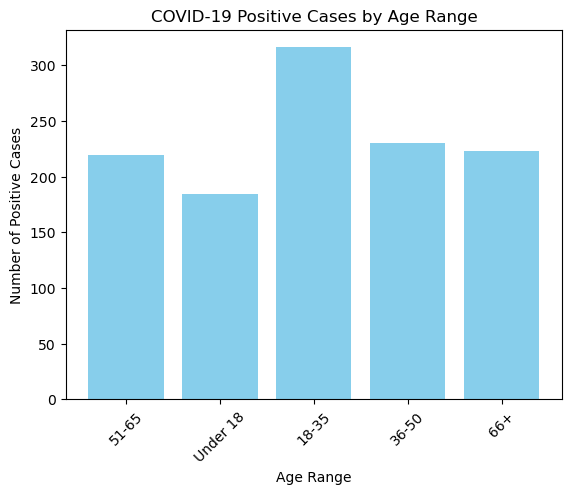

In [96]:
# Collect data to Python
data = age_group_count.collect()
age_ranges = [row['age_range'] for row in data]
counts = [row['count'] for row in data]

# Plot
plt.bar(age_ranges, counts, color='skyblue')
plt.xlabel('Age Range')
plt.ylabel('Number of Positive Cases')
plt.title('COVID-19 Positive Cases by Age Range')
plt.xticks(rotation=45)
plt.show()

In [97]:
# Group by date and count positive cases
date_count = covid_positive.groupBy(col("encounter.date").alias("date")).agg(count("*").alias("count"))

# Define a window specification for cumulative sum, ordering by date
window_spec = Window.orderBy("date")

# Add a cumulative sum column
date_cumsum = date_count.withColumn("cumulative_count", _sum("count").over(window_spec))


24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 2

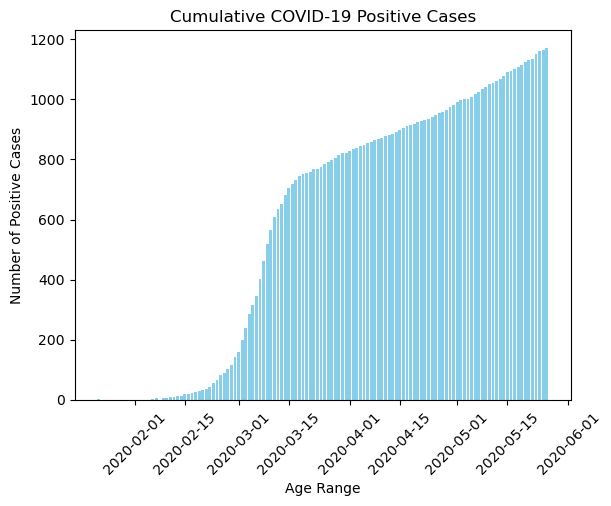

In [98]:
date_data = date_cumsum.collect()
dates = [row["date"] for row in date_data]
counts = [row["cumulative_count"] for row in date_data]

# Plot
plt.bar(dates, counts, color='skyblue')
plt.xlabel('Age Range')
plt.ylabel('Number of Positive Cases')
plt.title('Cumulative COVID-19 Positive Cases')
plt.xticks(rotation=45)
plt.show()


In [99]:
# Rank medications by frequency of prescription
medication_df = df.selectExpr("explode(medications) as medication")
medication_codes = medication_df.select(col("medication.code")).alias("code")
medication_counts = medication_codes.groupBy("code").agg(count("*").alias("frequency"))
window_spec = Window.orderBy(col("frequency").desc())
ranked_medications = medication_counts.withColumn("rank", F.rank().over(window_spec))
ranked_medications.show(5)


+-------+---------+----+
|   code|frequency|rank|
+-------+---------+----+
| 198440|      302|   1|
| 854235|      291|   2|
| 205923|      214|   3|
| 854252|      174|   4|
|2123111|      165|   5|
+-------+---------+----+
only showing top 5 rows



24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 20:38:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/13 2

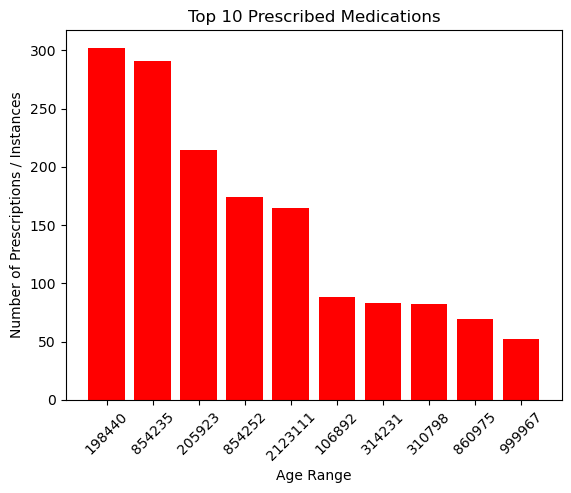

In [100]:
medication_data = ranked_medications.filter(col("rank") <= 10).collect()
codes = [row["code"] for row in medication_data]
frequency = [row["frequency"] for row in medication_data]

# Plot
plt.bar(codes, frequency, color='red')
plt.xlabel('Age Range')
plt.ylabel('Number of Prescriptions / Instances')
plt.title('Top 10 Prescribed Medications')
plt.xticks(rotation=45)
plt.show()

+---------+--------+--------------------+---------+----+
|age_range|med_code|     med_description|frequency|rank|
+---------+--------+--------------------+---------+----+
|    18-35|  198440|Acetaminophen 500...|       48|   1|
|    18-35|  854235|0.4 ML Enoxaparin...|       47|   2|
|    18-35|  854252|1 ML Enoxaparin s...|       29|   3|
+---------+--------+--------------------+---------+----+
only showing top 3 rows



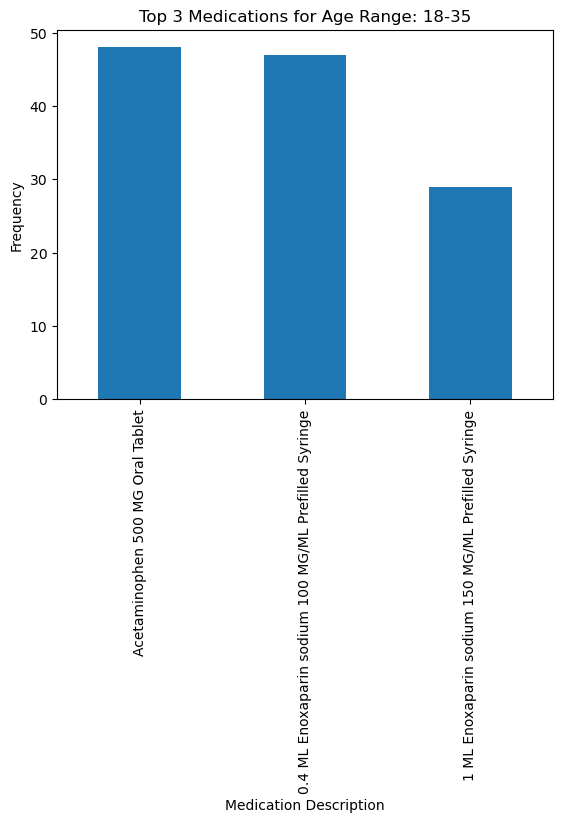

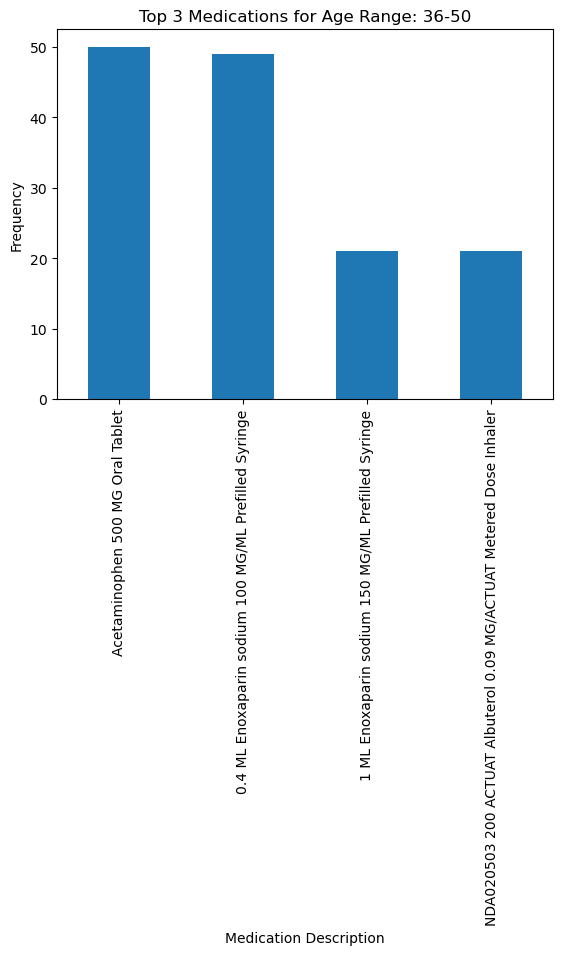

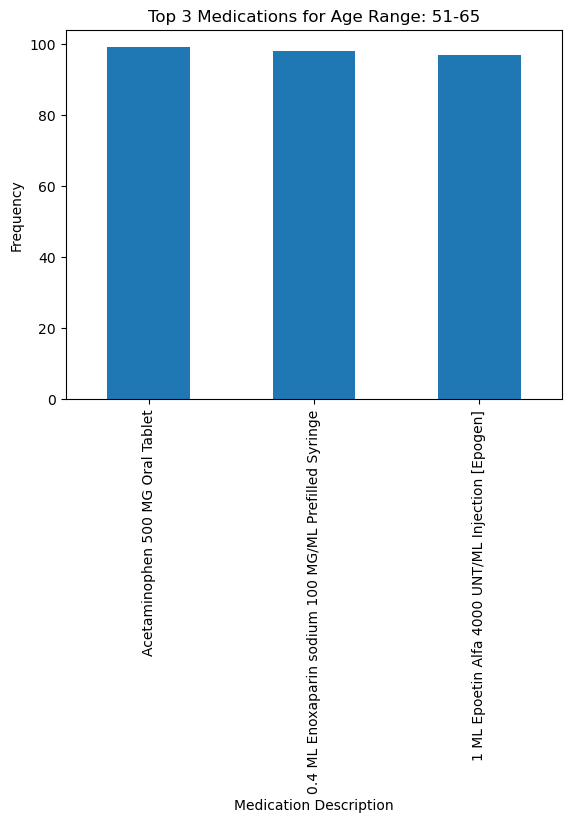

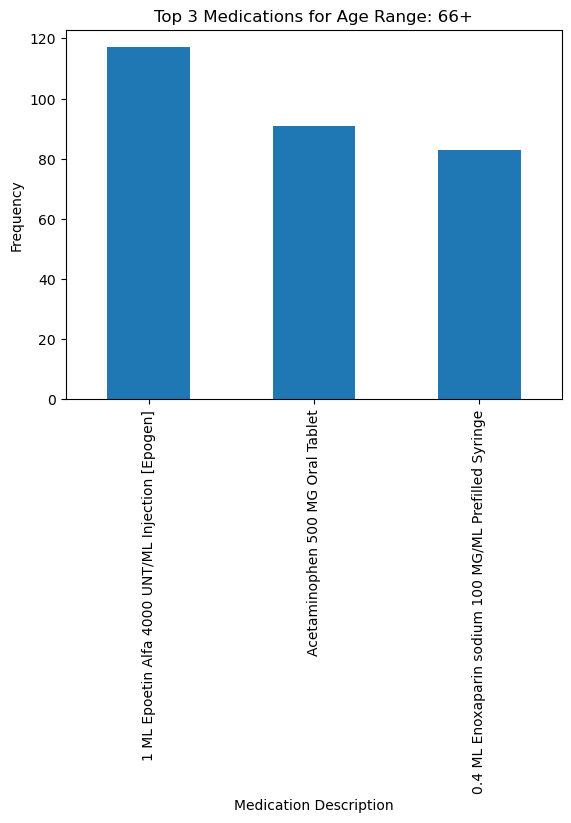

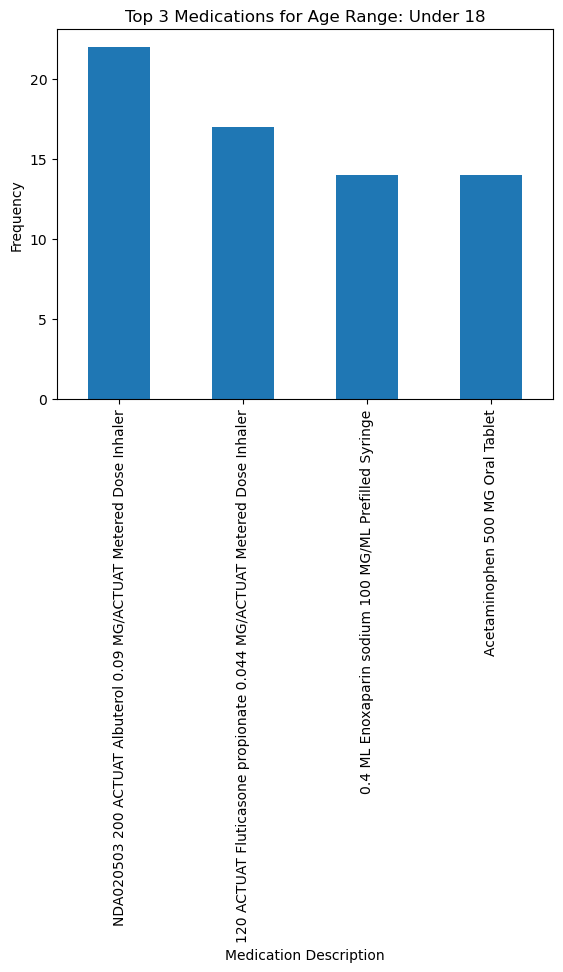

In [101]:
# Analyze medication patterns across different demographic groups (like top 3 per age group)

# Explode the medications array to create one row per medication
medications_df = df.selectExpr("explode(medications) as medication", "demographics.age as age")

# Extract medication code and description
medications_flat = medications_df.select(
    col("medication.code").alias("med_code"),
    col("medication.description").alias("med_description"),
    col("age")
)

# Define age ranges
medications_by_age = medications_flat.withColumn(
    "age_range",
    when(col("age") < 18, "Under 18")
    .when((col("age") >= 18) & (col("age") <= 35), "18-35")
    .when((col("age") > 35) & (col("age") <= 50), "36-50")
    .when((col("age") > 50) & (col("age") <= 65), "51-65")
    .otherwise("66+")
)

# Group by age range and medication, calculate frequency
medication_counts = medications_by_age.groupBy("age_range", "med_code", "med_description").agg(
    count("*").alias("frequency")
)

# Rank medications within each age group
window_spec = Window.partitionBy("age_range").orderBy(col("frequency").desc())
ranked_medications = medication_counts.withColumn("rank", rank().over(window_spec))

# Filter top 3 medications for each age group
top_3_medications = ranked_medications.filter(col("rank") <= 3)

# Show results
top_3_medications.orderBy("age_range", "rank").show(3)

# Optional: Convert to Pandas for Visualization

df_top_3 = top_3_medications.toPandas()
for age_range, group in df_top_3.groupby("age_range"):
    group.plot(kind="bar", x="med_description", y="frequency", legend=False)
    plt.title(f"Top 3 Medications for Age Range: {age_range}")
    plt.xlabel("Medication Description")
    plt.ylabel("Frequency")
    plt.show()


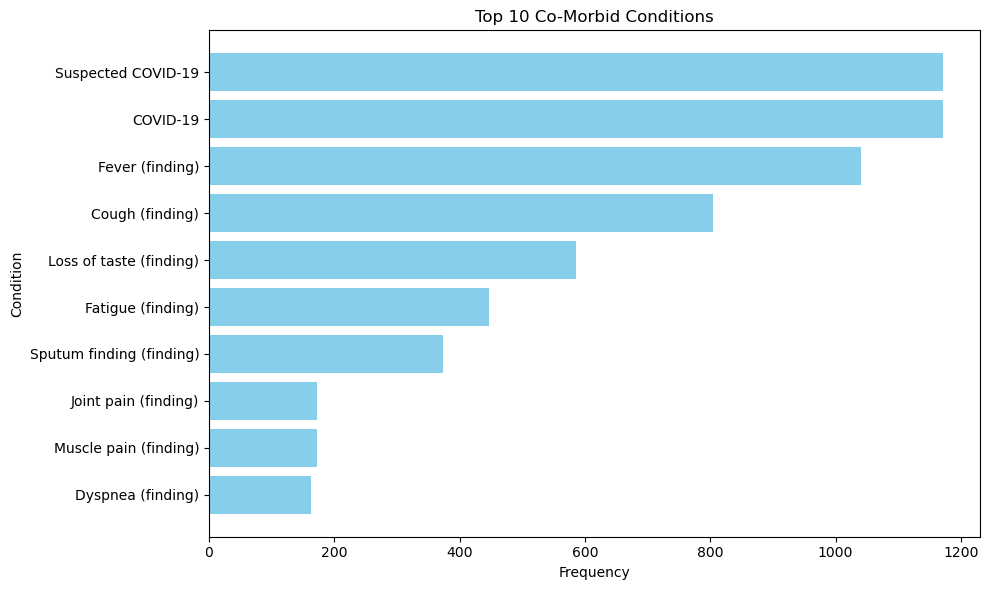

In [102]:
# Identify and plot co-morbidity information from the patient records (e.g. hypertension, obesity, prediabetes, etc.)

# Explode the conditions array
conditions_df = covid_positive.selectExpr("explode(conditions) as condition")

# Extract condition code and description
conditions_flat = conditions_df.select(
    col("condition.code").alias("condition_code"),
    col("condition.description").alias("condition_description")
)

# Group by condition and calculate frequencies
condition_counts = conditions_flat.groupBy("condition_description").agg(
    count("*").alias("frequency")
)

# Order by frequency descending
top_conditions = condition_counts.orderBy(col("frequency").desc())

# Collect top 10 conditions for visualization
top_10_conditions = top_conditions.limit(10).toPandas()

# Plot top 10 conditions
plt.figure(figsize=(10, 6))
plt.barh(top_10_conditions["condition_description"], top_10_conditions["frequency"], color="skyblue")
plt.xlabel("Frequency")
plt.ylabel("Condition")
plt.title("Top 10 Co-Morbid Conditions")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


## Independent Group Analysis
THREE original analyses providing meaningful insights about COVID-19.

### 1. Correlation Between Age and Disease Severity

+---------+--------+-----+
|age_range|severity|count|
+---------+--------+-----+
|    36-50|  Severe|  230|
| Under 18|  Severe|  184|
|    18-35|  Severe|  316|
+---------+--------+-----+
only showing top 3 rows



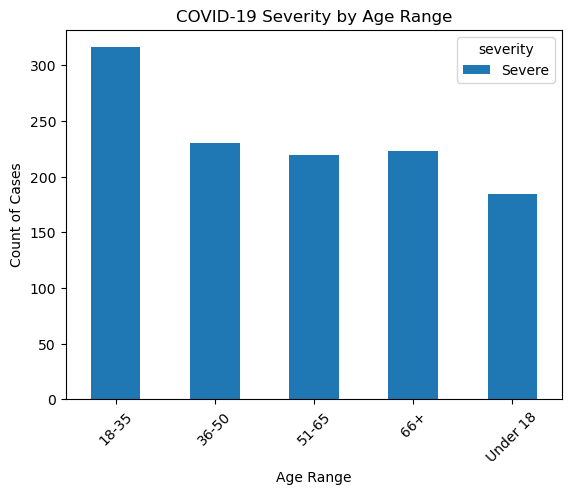

In [103]:
from pyspark.sql.functions import col, when, count

# Create a severity column based on thresholds
covid_severity = covid_positive.withColumn(
    "severity",
    when(col("vitals.current.oxygen_saturation.value") < 90, "Severe")
    .when((col("vitals.current.oxygen_saturation.value") >= 90) & (col("vitals.current.respiratory_rate.value") > 20), "Moderate")
    .otherwise("Mild")
)

# Group by age range and severity
age_severity = covid_severity.withColumn(
    "age_range",
    when(col("demographics.age") < 18, "Under 18")
    .when((col("demographics.age") >= 18) & (col("demographics.age") <= 35), "18-35")
    .when((col("demographics.age") > 35) & (col("demographics.age") <= 50), "36-50")
    .when((col("demographics.age") > 50) & (col("demographics.age") <= 65), "51-65")
    .otherwise("66+")
).groupBy("age_range", "severity").agg(count("*").alias("count"))

# Show results
age_severity.show(3)

df_pandas = age_severity.toPandas()
pivot = df_pandas.pivot(index="age_range", columns="severity", values="count").fillna(0)
pivot.plot(kind="bar", stacked=True)
plt.xlabel("Age Range")
plt.ylabel("Count of Cases")
plt.title("COVID-19 Severity by Age Range")
plt.xticks(rotation=45)
plt.show()


### 2. Geographic Spread and Clusters of Positive Cases

+---------+-------------+-----+
|     city|        state|count|
+---------+-------------+-----+
|   Boston|Massachusetts|  117|
|Worcester|Massachusetts|   37|
|   Lowell|Massachusetts|   26|
+---------+-------------+-----+
only showing top 3 rows



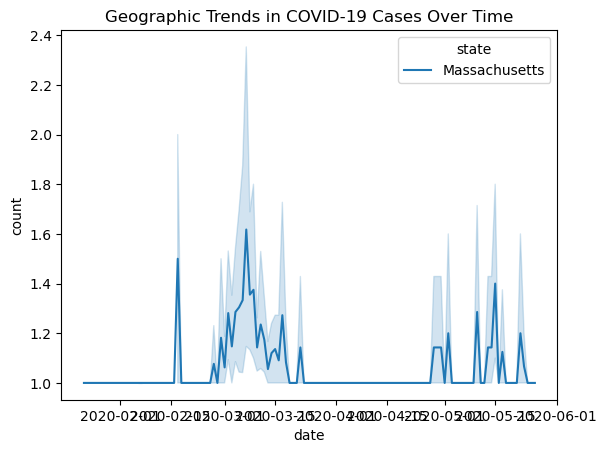

In [104]:
# Group cases by city and state
geo_cases = covid_positive.groupBy(
    col("demographics.address.city").alias("city"),
    col("demographics.address.state").alias("state")
).agg(count("*").alias("count"))

# Sort by count descending
geo_cases_sorted = geo_cases.orderBy(col("count").desc())

# Show top cities/states with the highest case counts
geo_cases_sorted.show(3)

# Optional: Trend over time
geo_trend = covid_positive.groupBy(
    col("demographics.address.city").alias("city"),
    col("demographics.address.state").alias("state"),
    col("encounter.date").alias("date")
).agg(count("*").alias("count")).orderBy("date")

# Visualize geographic trends (e.g., heatmaps)
import seaborn as sns
df_geo_trend = geo_trend.toPandas()
sns.lineplot(data=df_geo_trend, x="date", y="count", hue="state")
plt.title("Geographic Trends in COVID-19 Cases Over Time")
plt.show()

### 3. Impact of Pre-Existing Conditions on Positive Cases

+---------------------+---------+
|condition_description|frequency|
+---------------------+---------+
|   Suspected COVID-19|     1172|
|             COVID-19|     1172|
|      Fever (finding)|     1040|
+---------------------+---------+
only showing top 3 rows



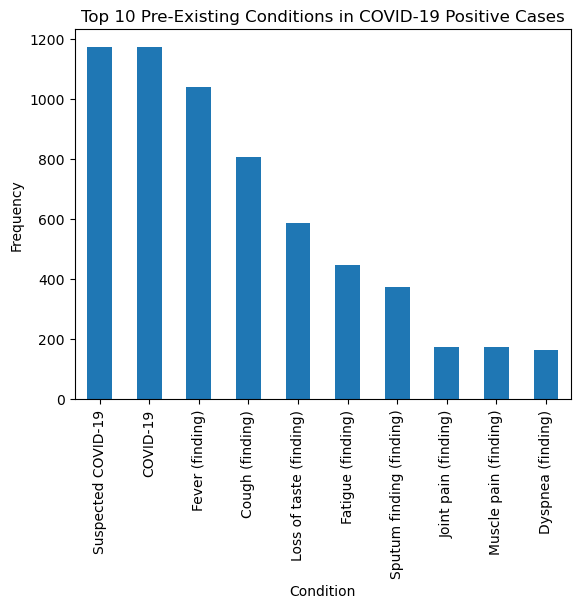

In [105]:

# Explode conditions array to create one row per condition
conditions_df = covid_positive.selectExpr("explode(conditions) as condition")

# Extract code and description from condition struct
conditions_flat = conditions_df.select(
    col("condition.code").alias("condition_code"),
    col("condition.description").alias("condition_description")
)

# Group and count occurrences of each condition
condition_counts = conditions_flat.groupBy("condition_description").agg(count("*").alias("frequency"))

# Sort by frequency
condition_counts_sorted = condition_counts.orderBy(col("frequency").desc())

# Show top conditions
condition_counts_sorted.show(3)

# Optional: Visualize the most common conditions
df_conditions = condition_counts_sorted.limit(10).toPandas()
df_conditions.plot(kind="bar", x="condition_description", y="frequency", legend=False)
plt.title("Top 10 Pre-Existing Conditions in COVID-19 Positive Cases")
plt.xlabel("Condition")
plt.ylabel("Frequency")
# plt.xticks(rotation=45)
plt.show()
